# SHM with LNN
- train with true gradient at each time step

## TODO:

- data with dq vs data without dq
- the loss function will be different
- We assume we have dq here
- Try weighted trajectory

In [1]:
import numpy as np
import torch

import sys
sys.path.append("../../")

## Train Model

In [2]:
# hparams
batch_size = 512
learning_rate = 3e-4
min_delta=0
patience=20

time_horizon = 5
solver = 'rk4'

model_name = 'SHM_LNN_ODE.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Create the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from data import SHM_1D_ODE_DataModule

In [5]:
init_conditions = [
        (1, 0, 0, 2. * np.pi, 500),
        (2, 0, 0, 2. * np.pi, 500),
        (0.5, 0, 0, 2. * np.pi, 500),
        (1.5, 0, 0, 2. * np.pi, 500)
]

# 2 for finite difference
dataModule = SHM_1D_ODE_DataModule(init_conditions=init_conditions,
                                   time_horizon=time_horizon,
                                   batch_size=batch_size)
dataModule.setup()

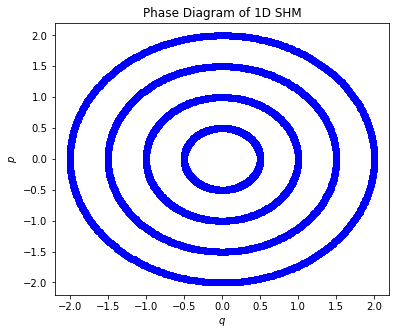

In [6]:
dataModule.plot_data(train=True)

### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module import LNN
from nn import MLP

In [8]:
lagrangianNet = MLP([2, 64, 64, 1], activation='softplus')
lagFunc = LNN(num_angle=0, lagrangianNet=lagrangianNet)

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

### Pretrain with time horizon = 2

In [9]:
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [10]:
class Pre_learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.time_horizon = 2

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, _, _, t = batch
        xs0 = x[:, 0, :]
        t_span = t[0, :self.time_horizon, 0]
        cur_x_hat = self.model.trajectory(xs0, t_span)
        loss = self.loss_func(x[:, :self.time_horizon, :], cur_x_hat.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [11]:
pre_Learn = Pre_learner(lagODE)
pre_trainer = pl.Trainer(max_epochs=10)
pre_trainer.fit(pre_Learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f'you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop')

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 4.4 K 
------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init 

Training: 0it [00:00, ?it/s]

### Define Pytorch lightning trainer

In [12]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, _, _, t = batch

        # x: (bs, t, [q, dq])
        xs0 = x[:, 0, :]
        # t: (bs, t, 0)
        t_span = t[0, :, 0]  # Assume all trajectory have the same time stamps, which only work for model.trajectory

        # take X (bs, dim), and t (number of time steps)
        # and output the trajectory in system of 1st order ODE
        cur_x_hat = self.model.trajectory(xs0, t_span)
        # return shape (time, batch, dim)
        
        loss = self.loss_func(x, cur_x_hat.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _, _, t = batch
        xs0 = x[:, 0, :]
        t_span = t[0, :, 0]
        
        cur_x_hat = self.model.trajectory(xs0, t_span)
        
        loss = self.loss_func(x, cur_x_hat.transpose(0, 1))
        
        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [13]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [14]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 4.4 K 
------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.001
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.000. Signaling Trainer to stop.


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [15]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [17]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Compare trajectory with test set

In [18]:
from utils import SHM_1D_model

In [19]:
# Generate Trajectory from true model
x0 = 4
p0 = 0
t0 = 0
t1 = 50
steps = 1000

q_p, dq_dp, _, ts = SHM_1D_model(x0=x0, p0=p0, t0=t0, t1=t1, steps=steps)

# Generate Estimated Trajectory
t_span = torch.linspace(t0, t1, steps)

traj = test_model.trajectory(q_p[[0], :], t_span).detach()  # (time, points, dim)

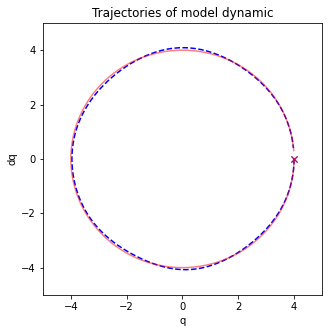

In [20]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

length = 125
ax1.plot(traj[:length, 0, 0], traj[:length, 0, 1], '--', color='blue')  # traj
ax1.plot(traj[0, 0, 0], traj[0, 0, 1], marker='x', color="blue")  # init pos

ax1.plot(q_p[:length, 0], q_p[:length, 1], color='red', alpha=0.5)  # traj
ax1.plot(q_p[0, 0], q_p[0, 1], marker='x', color="red")  # init pos

ax1.set_xlim([-5., 5.])
ax1.set_ylim([-5., 5.])
ax1.set_xlabel("q")
ax1.set_ylabel("dq")
ax1.set_title("Trajectories of model dynamic")

None

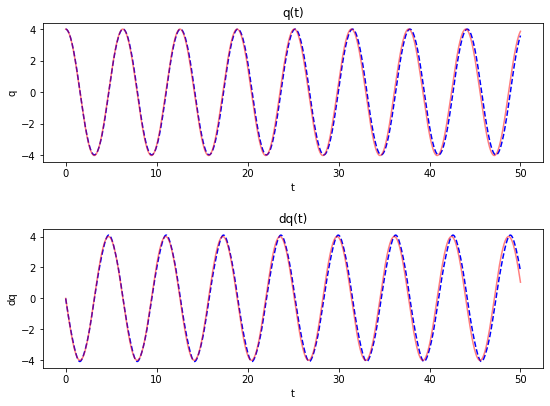

In [21]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)

length = 2000
ax1.plot(t_span, traj[:length, 0, 0], '--', color='blue')  # traj
ax1.plot(ts[:length], q_p[:length, 0], color='red', alpha=0.5)

# ax1.set_ylim([-10, 10])
ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span, traj[:length, 0, 1], '--', color='blue')  # traj
ax2.plot(ts[:length], q_p[:length, 1], color='red', alpha=0.5)

# ax2.set_ylim([-10, 10])
ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

fig.tight_layout(pad=2.0)
None

### Plot the Vector field in phase space

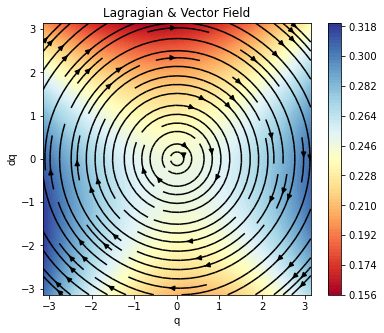

In [22]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
Q, P = torch.meshgrid(x, x)  # all (q, p)

# H is Hamiltonian
# (U, V) are the symplectic gradient
L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), P[i, j].reshape(1, 1)], 1)
        L[i, j] = test_model.defunc.m.L(x).detach().cpu()
        grad = test_model.defunc(0, x).detach().cpu()
        U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, P, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), P.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([P.min(), P.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagragian & Vector Field")
None

### Plot 3D surface plot of Lagrangian

In [23]:
ground_truth = None

# Define the true Hamiltonian Here
def SHM_lagrangian(q, p, k=1., m=1.):
    return p ** 2. / (2. * m) - k * q ** 2. / 2.

ground_truth = SHM_lagrangian

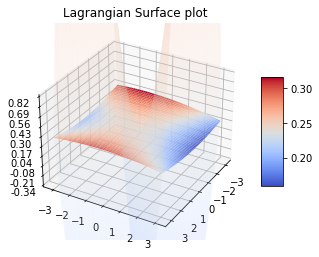

In [24]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
Q, P = torch.meshgrid(x, x)  # all (q, p)

L = torch.zeros(Q.shape)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), P[i, j].reshape(1, 1)], 1)
        L[i, j] = test_model.defunc.m.L(x).detach()

# Plot the surface
surf = ax.plot_surface(Q.numpy(), P.numpy(), L.numpy(),
                       cmap='coolwarm')

if ground_truth is not None:
    L_true = ground_truth(Q, P) + L[int(n_grid / 2), int(n_grid / 2)]  # offset to see to compare
    _ = ax.plot_surface(Q.numpy(), P.numpy(), L_true.numpy(),
                        cmap='coolwarm', alpha=0.2)

# Customize the z axis.
ax.set_zlim(L.min() - 0.5, L.max() + 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(30, 30)

ax.set_title("Lagrangian Surface plot")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

None

### Plot Hamiltonian through legendre transform

In [25]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
Q, dQ = torch.meshgrid(x, x)  # all (q, p)

# H is Hamiltonian
# (U, V) are the symplectic gradient
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

P = torch.zeros_like(dQ)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
        H[i, j], P[i, j] = test_model.defunc.m.H_p_legendre(x)
        grad = test_model.defunc(0, x).detach().cpu()
        U[i, j], V[i, j] = grad[:, 0], grad[:, 1]
        
P = P.detach().numpy()

# Momentum is ambiguous here
# P_est = np.mean(P, axis=0)
# err = np.std(P, axis=0)
# P[:, 0]
# P_est = np.tile(P_est, (n_grid,1))

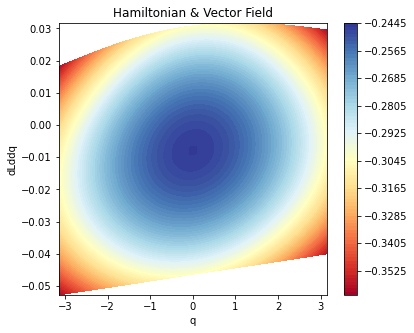

In [26]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, P, H.detach().numpy(), 100, cmap='RdYlBu')
fig.colorbar(CS)

# ax.streamplot(Q.T.numpy(), P_est.T, U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([P.min(), P.max()])
ax.set_xlabel("q")
ax.set_ylabel("dLddq")
ax.set_title("Hamiltonian & Vector Field")
None

## Conclusion

- Loss can easily blow up with large trajectory
    - for t > 2, loss are nan, coz the trajecotry just blow toward inf